# LKJ Cholesky Covariance Priors for Multivariate Normal Models

While the [inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution) is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is [not very well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) to modern Bayesian computational methods.  For this reason, the [LKJ prior](http://www.sciencedirect.com/science/article/pii/S0047259X09000876) is recommended when modeling the covariance matrix of a multivariate normal distribution.

To illustrate modelling covariance with the LKJ distribution, we first generate a two-dimensional normally-distributed sample data set.

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

print(f"Running on PyMC3 v{pm.__version__}")

pm.__file__

Running on PyMC3 v4.0.0b2


'/home/martin/projects/pymc3_vs_stan/pymc/pymc/__init__.py'

In [2]:
import aesara
aesara.__version__

'2.3.8'

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
N = 10000

μ_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Σ_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = rng.multivariate_normal(μ_actual, Σ_actual, size=N)
Σ_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

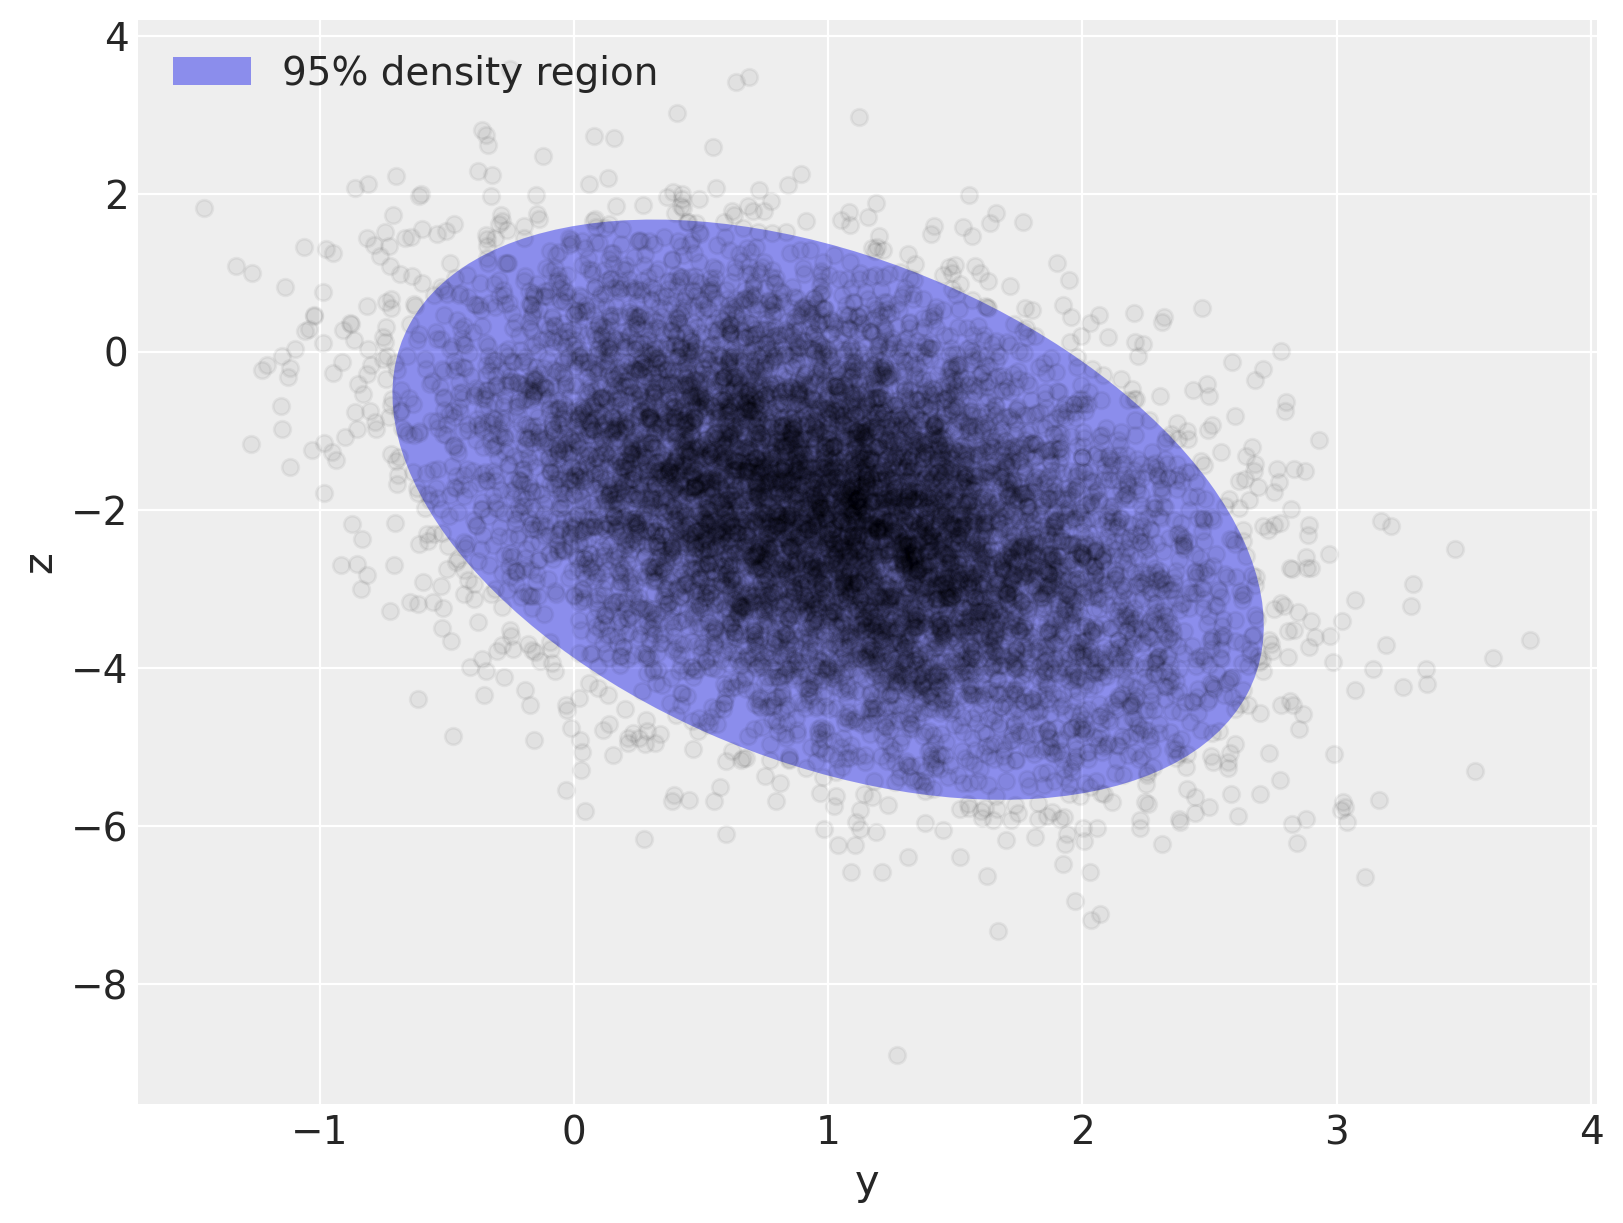

In [5]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor("C0")
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)
ax.set_xlabel("y")
ax.set_ylabel("z")

rect = plt.Rectangle((0, 0), 1, 1, fc="C0", alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

The sampling distribution for the multivariate normal model is $\mathbf{x} \sim N(\mu, \Sigma)$, where $\Sigma$ is the covariance matrix of the sampling distribution, with $\Sigma_{ij} = \textrm{Cov}(x_i, x_j)$. The density of this distribution is

$$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right).$$

The LKJ distribution provides a prior on the correlation matrix, $\mathbf{C} = \textrm{Corr}(x_i, x_j)$, which, combined with priors on the standard deviations of each component, [induces](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) a prior on the covariance matrix, $\Sigma$. Since inverting $\Sigma$ is numerically unstable and inefficient, it is computationally advantageous to use the [Cholesky decompositon](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, $\Sigma = \mathbf{L} \mathbf{L}^{\top}$, where $\mathbf{L}$ is a lower-triangular matrix. This decompositon allows computation of the term $(\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)$ using back-substitution, which is more numerically stable and efficient than direct matrix inversion.

PyMC3 supports LKJ priors for the Cholesky decomposition of the covariance matrix via the [LKJCholeskyCov](../api/distributions/multivariate.rst) distribution. This distribution has parameters `n` and `sd_dist`, which are the dimension of the observations, $\mathbf{x}$, and the PyMC3 distribution of the component standard deviations, respectively. It also has a hyperparamter `eta`, which controls the amount of correlation between components of $\mathbf{x}$. The LKJ distribution has the density $f(\mathbf{C}\ |\ \eta) \propto |\mathbf{C}|^{\eta - 1}$, so $\eta = 1$ leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as $\eta \to \infty$.

In this example, we model the standard deviations with $\textrm{Exponential}(1.0)$ priors, and the correlation matrix as $\mathbf{C} \sim \textrm{LKJ}(\eta = 2)$.

In [6]:
with pm.Model() as m:
    packed_L, corr, stds = pm.LKJCholeskyCov("packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0))
    
packed_L

AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True}.0

Since the Cholesky decompositon of $\Sigma$ is lower triangular, `LKJCholeskyCov` only stores the diagonal and sub-diagonal entries, for efficiency:

We use [expand_packed_triangular](../api/math.rst) to transform this vector into the lower triangular matrix $\mathbf{L}$, which appears in the Cholesky decomposition $\Sigma = \mathbf{L} \mathbf{L}^{\top}$.

Often however, you'll be interested in the posterior distribution of the correlations matrix and of the standard deviations, not in the posterior Cholesky covariance matrix *per se*. Why? Because the correlations and standard deviations are easier to interpret and often have a scientific meaning in the model. As of PyMC 3.9, there is a way to tell PyMC to automatically do these computations and store the posteriors in the trace. You just have to specify `compute_corr=True` in `pm.LKJCholeskyCov`:

In [10]:
coords = {"axis": ["y", "z"], "axis_bis": ["y", "z"], "obs_id": np.arange(N)}
with pm.Model(coords=coords) as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=True
    )

To complete our model, we place independent, weakly regularizing priors, $N(0, 1.5),$ on $\mu$:

In [11]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, dims="axis")
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x, dims=("obs_id", "axis"))

We sample from this model using NUTS and give the trace to [ArviZ](https://arviz-devs.github.io/arviz/):

In [ ]:
with model:
    trace = pm.sample(
        random_seed=RANDOM_SEED,
        init="adapt_diag",
    )
az.summary(trace, var_names="~chol", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/home/martin/miniconda3/envs/dl/lib/python3.8/site-packages/aeppl/joint_logprob.py:161: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: normal_rv{0, (0, 0), floatX, False}(RandomStateSharedVariable(<RandomState(MT19937) at 0x7FC4AB8F8E40>), TensorConstant{[]}, TensorConstant{11}, BroadcastTo.0, BroadcastTo.0)
  warnings.warn(


Sampling went smoothly: no divergences and good r-hats (except for the diagonal elements of the correlation matrix - however, these are not a concern, because, they should be equal to 1 for each sample for each chain and the variance of a constant value isn't defined. If one of the diagonal elements has `r_hat` defined, it's likely due to tiny numerical errors). 
 
You can also see that the sampler recovered the true means, correlations and standard deviations. As often, that will be clearer in a graph:

In [ ]:
az.plot_trace(
    trace,
    var_names="chol_corr",
    coords={"axis": "y", "axis_bis": "z"},
    lines=[("chol_corr", {}, Rho_actual[0, 1])],
);

In [ ]:
az.plot_trace(
    trace,
    var_names=["~chol", "~chol_corr"],
    compact=True,
    lines=[
        ("μ", {}, μ_actual),
        ("cov", {}, Σ_actual),
        ("chol_stds", {}, sigmas_actual),
    ],
);

The posterior expected values are very close to the true value of each component! How close exactly? Let's compute the percentage of closeness for $\mu$ and $\Sigma$:

In [ ]:
μ_post = trace.posterior["μ"].mean(("chain", "draw")).values
(1 - μ_post / μ_actual).round(2)

In [ ]:
Σ_post = trace.posterior["cov"].mean(("chain", "draw")).values
(1 - Σ_post / Σ_actual).round(2)

So the posterior means are within 3% of the true values of $\mu$ and $\Sigma$.

Now let's replicate the plot we did at the beginning, but let's overlay the posterior distribution on top of the true distribution -- you'll see there is excellent visual agreement between both:

In [ ]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(
    μ_actual,
    2 * np.sqrt(5.991 * var[0]),
    2 * np.sqrt(5.991 * var[1]),
    angle=angle,
    linewidth=3,
    linestyle="dashed",
)
e.set_edgecolor("C0")
e.set_zorder(11)
e.set_fill(False)
ax.add_artist(e)

e_post = Ellipse(
    μ_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
    linewidth=3,
)
e_post.set_edgecolor("C1")
e_post.set_zorder(10)
e_post.set_fill(False)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)
ax.set_xlabel("y")
ax.set_ylabel("z")

line = Line2D([], [], color="C0", linestyle="dashed", label="True 95% density region")
line_post = Line2D([], [], color="C1", label="Estimated 95% density region")
ax.legend(
    handles=[line, line_post],
    loc=2,
);

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray